In [ ]:
!pip install pandas numpy transformers matplotlib

     |████████████████████████████████| 1.1MB 2.4MB/s 
     |████████████████████████████████| 3.0MB 14.7MB/s 
     |████████████████████████████████| 890kB 21.4MB/s 
     |████████████████████████████████| 1.1MB 21.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=6603b6213cd1f32cef9f9012d54761d6fe147110305028ca5027a01009465ba4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Preprocessing

In [ ]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.77.214.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.77.214.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#import local file
from google.colab import files
uploaded = files.upload()

Saving NLP Email Annotations - dataWithOutboundBody (please label this Sheet).csv to NLP Email Annotations - dataWithOutboundBody (please label this Sheet).csv


In [ ]:
import io
raw_data = pd.read_csv(io.BytesIO(uploaded['NLP Email Annotations.csv']))

KeyError: ignored

In [ ]:
#creating a new column with colsolidated labels from both Google Sheets
raw_data['Human Label (Consolidated)'] = np.nan
raw_data['Human Label  (Consolidated)'] = raw_data['Human Label (Consolidated)'].fillna(raw_data['Human Label']).fillna(raw_data['Label(FROM SHEET1)']).fillna(raw_data['Human Label(FROM SHEET1)'])
raw_data = raw_data.drop(['Human Label'],axis=1)
raw_data['Human Label'] = raw_data['Human Label  (Consolidated)']


In [ ]:
from IPython.display import display
#display(print('Human Label Counts before Conolidation:'), raw_data['Human Label'].value_counts())
display(print('Human Label Counts after Conolidation:'), raw_data['Human Label'].value_counts())

In [ ]:
len(raw_data)

In [ ]:
# valid_label = ['N','R','C']
# raw_data = raw_data[raw_data['Human Label (Consolidated)'].isin(valid_label)]

In [ ]:
# len(raw_data)

In [ ]:
raw_data = raw_data.dropna(subset=["OUTBOUND_SUBJECT","OUTBOUND_BODY","INBOUND_BODY","Human Label"])

In [ ]:
len(raw_data)

In [ ]:
import pandas as pd
import numpy as np

# Download the data from the session storage, remove any row with null values and randomize the rows.
raw_data = pd.read_csv('./NLP Email Annotations - 10:14.csv').dropna(subset=["OUTBOUND_SUBJECT","OUTBOUND_BODY","INBOUND_BODY","Human Label"]).sample(frac=1)
print(raw_data.shape)

(685, 14)


In [ ]:

raw_data["OUT_BODY_LENGTH"] = raw_data["OUTBOUND_BODY"].map(lambda x:len(x.split()))


OUT_BODY_LENGTH    43.0
dtype: float64

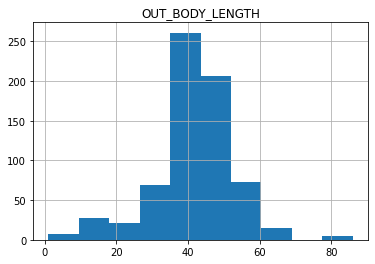

In [ ]:
raw_data.hist(column=["OUT_BODY_LENGTH"])
raw_data.median(numeric_only=True)

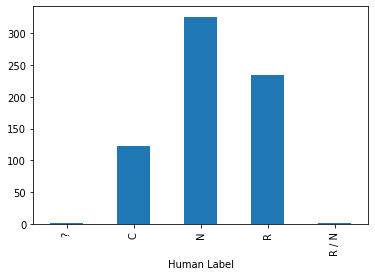

In [ ]:

raw_data.groupby(["Human Label"]).size().plot.bar()

OUT_BODY_LENGTH    35.0
dtype: float64

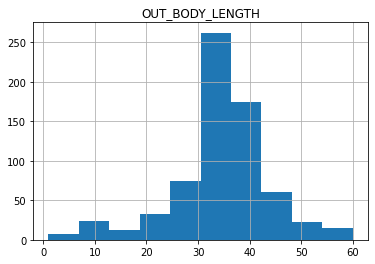

In [ ]:
# Make sure the labels only contain 'R','C' or 'N'.
raw_data["Human Label"] = raw_data["Human Label"].map(lambda x:x if x == 'C' or x == 'R' else 'N' )
# The outbound body can be quite large so we are only gonna take the first 60 tokens/words
sep = ' '
raw_data["OUTBOUND_BODY"] = raw_data["OUTBOUND_BODY"].map(lambda x:sep.join(x.split(sep)[:60]))
raw_data["INBOUND_BODY"] = raw_data["INBOUND_BODY"].map(lambda x:sep.join(x.split(sep)[:120]))
raw_data["OUT_BODY_LENGTH"] = raw_data["OUTBOUND_BODY"].map(lambda x:len(x.split(sep)))
raw_data.hist(column=["OUT_BODY_LENGTH"])
raw_data.median(numeric_only=True)

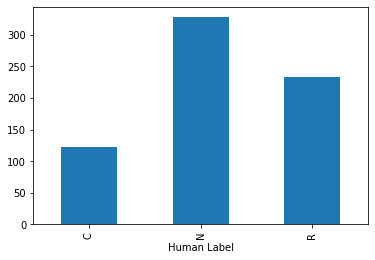

In [ ]:
raw_data.groupby(["Human Label"]).size().plot.bar()

In [ ]:
# Create a new column that combines the subject and description
raw_data['text'] = raw_data['OUTBOUND_SUBJECT']+ '|' + raw_data['INBOUND_BODY'] + '|' + raw_data['OUTBOUND_BODY'] 
emails = raw_data[['text','Human Label']]

# Labels need to be converted to an index list, so first get all the labels in a list
# then get the label index as the new value
labels = emails['Human Label'].unique().tolist()
labels_dict = {}
for i,x in enumerate(labels):
  labels_dict[x]=i

emails['label_id'] = emails['Human Label'].apply(lambda x: labels_dict[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 1041 to 132
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         685 non-null    object
 1   Human Label  685 non-null    object
 2   label_id     685 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.4+ KB


In [ ]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636 entries, 727 to 547
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         636 non-null    object
 1   Human Label  636 non-null    object
 2   label_id     636 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 19.9+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(emails['text'], emails['label_id'], test_size=.1)

Data needs to be tokenized before being fed into the model


In [ ]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# The tokenizer is goning to convert the input string into the values that the 
# model understands. This is also gonna take care of truncating sentences that are
# bigger than 512 tokens, and to pad all the ones that are shorter than that
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

(array([ 53., 166., 141.,  97.,  51.,  47.,  33.,  12.,  12.,   4.]),
 array([ 50. ,  96.2, 142.4, 188.6, 234.8, 281. , 327.2, 373.4, 419.6,
        465.8, 512. ]),
 <a list of 10 Patch objects>)

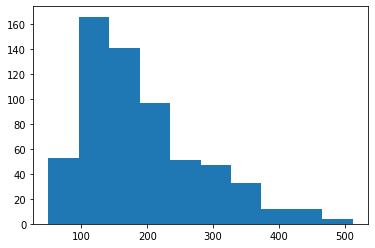

In [ ]:
import matplotlib.pyplot as plt
train_encodings_2 = tokenizer(train_texts.tolist(), truncation=True, padding=False)
x = [len(enc) for enc in train_encodings_2["input_ids"]]
plt.hist(x)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import datetime

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

# Model Training

In [ ]:
from transformers import TFBertForSequenceClassification
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels), id2label = labels  )
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
  model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=[
      tf.keras.metrics.SparseCategoricalAccuracy(),
      tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2),
  ])
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=30, batch_size=16)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 2/39 [>.............................] - ETA: 10:58 - loss: 1.0827 - sparse_categorical_accuracy: 0.3438 - sparse_top_k_categorical_accuracy: 0.8438WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0081s vs `on_train_batch_end` time: 0.1243s). Check your callbacks.


39/39 [==============================] - 40s 1s/step - loss: 1.0418 - sparse_categorical_accuracy: 0.4562 - sparse_top_k_categorical_accuracy: 0.8198
Epoch 2/30
39/39 [==============================] - 5s 131ms/step - loss: 1.0079 - sparse_categorical_accuracy: 0.5016 - sparse_top_k_categorical_accuracy: 0.8247
Epoch 3/30
39/39 [==============================] - 5s 135ms/step - loss: 1.0047 - sparse_categorical_accuracy: 0.5081 - sparse_top_k_categorical_accuracy: 0.8247
Epoch 4/30
39/39 [==============================] - 5s 133ms/step - loss: 0.9553 - sparse_categorical_accuracy: 0.5406 - sparse_top_k_categorical_accuracy: 0.8344
Epoch 5/30
39/39 [==============================] - 5s 132ms/step - loss: 0.9030 - sparse_categorical_accuracy: 0.5942 - sparse_top_k_categorical_accuracy: 0.8620
Epoch 6/30
39/39 [==============================] - 5s 131ms/step - loss: 0.7784 - sparse_categorical_accuracy: 0.6575 - sparse_top_k_categorical_accuracy: 0.8815
Epoch 7/30
39/39 [=================

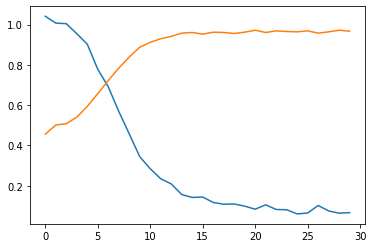

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['sparse_categorical_accuracy'])

In [ ]:
test_dataset.element_spec
results = model.evaluate(test_dataset.batch(1), batch_size=1)
dict(zip(model.metrics_names, results))

 2/69 [..............................] - ETA: 4:10 - loss: 2.4954 - sparse_categorical_accuracy: 0.5000 - sparse_top_k_categorical_accuracy: 1.0000WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0040s vs `on_test_batch_end` time: 0.0479s). Check your callbacks.


69/69 [==============================] - 11s 160ms/step - loss: 1.2392 - sparse_categorical_accuracy: 0.6812 - sparse_top_k_categorical_accuracy: 0.9565


{'loss': 1.2391644716262817,
 'sparse_categorical_accuracy': 0.6811593770980835,
 'sparse_top_k_categorical_accuracy': 0.9565216898918152}

In [ ]:
test_dataset.element_spec
results = model.evaluate(test_dataset.batch(1), batch_size=1)
dict(zip(model.metrics_names, results))

 2/69 [..............................] - ETA: 3s - loss: 2.4954 - sparse_categorical_accuracy: 0.5000 - sparse_top_k_categorical_accuracy: 1.0000WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0056s vs `on_test_batch_end` time: 0.0454s). Check your callbacks.


69/69 [==============================] - 3s 50ms/step - loss: 1.2392 - sparse_categorical_accuracy: 0.6812 - sparse_top_k_categorical_accuracy: 0.9565


{'loss': 1.2391644716262817,
 'sparse_categorical_accuracy': 0.6811593770980835,
 'sparse_top_k_categorical_accuracy': 0.9565216898918152}

In [ ]:
from sklearn.metrics import confusion_matrix
model_results = model.predict(test_dataset.batch(5),batch_size=5)
y_pred = model_results[0].argmax(axis=1)
pred_matrix = confusion_matrix(test_labels, y_pred)
print(pred_matrix)

[[ 4  4  6]
 [ 1 23  4]
 [ 6  1 20]]


In [ ]:
from sklearn.metrics import confusion_matrix
model_results = model.predict(test_dataset.batch(5),batch_size=5)
y_pred = model_results[0].argmax(axis=1)
pred_matrix = confusion_matrix(test_labels, y_pred)
print(pred_matrix)

[[ 7  3  4]
 [ 3 28  3]
 [ 4  4  8]]


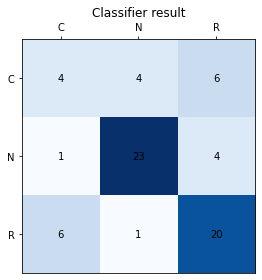

In [ ]:


fig, ax = plt.subplots()
im = ax.imshow(pred_matrix, cmap='Blues')

# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(pred_matrix)):
    for j in range(len(pred_matrix[0])):
        text = ax.text(j, i, pred_matrix[i, j],
                       ha="center", va="center")

ax.set_title("Classifier result")
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
fig.tight_layout()
plt.show()

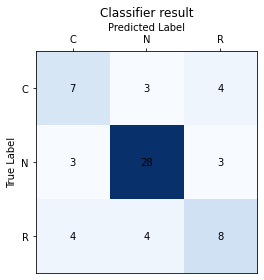

In [ ]:


fig, ax = plt.subplots()
im = ax.imshow(pred_matrix, cmap='Blues')

# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(pred_matrix)):
    for j in range(len(pred_matrix[0])):
        text = ax.text(j, i, pred_matrix[i, j],
                       ha="center", va="center")

ax.set_title("Classifier result")
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from pprint import pprint
pprint(classification_report(test_labels, y_pred, target_names=labels))

('              precision    recall  f1-score   support\n'
 '\n'
 '           C       0.50      0.50      0.50        14\n'
 '           N       0.80      0.82      0.81        34\n'
 '           R       0.53      0.50      0.52        16\n'
 '\n'
 '    accuracy                           0.67        64\n'
 '   macro avg       0.61      0.61      0.61        64\n'
 'weighted avg       0.67      0.67      0.67        64\n')


In [ ]:
from sklearn.metrics import classification_report
from pprint import pprint
pprint(classification_report(test_labels, y_pred, target_names=labels))

('              precision    recall  f1-score   support\n'
 '\n'
 '           C       0.50      0.50      0.50        14\n'
 '           N       0.80      0.82      0.81        34\n'
 '           R       0.53      0.50      0.52        16\n'
 '\n'
 '    accuracy                           0.67        64\n'
 '   macro avg       0.61      0.61      0.61        64\n'
 'weighted avg       0.67      0.67      0.67        64\n')


In [ ]:
from transformers import TextClassificationPipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [ ]:
classifier("""
⚠ Urgent Live Pickup Appointment Needed: 3681093564| Jesse, 


Appointment/Work-In Request: Today 9/25 at 14:30 (2:30pm)


Please confirm this time works for your facility. 

Thanks,
Fatimaa Howell | This appointment is good for us. Thanks a lot

Get Outlook for Android<https://aka.ms/ghei36>

""")

[{'label': 'C', 'score': 0.9958077073097229}]

In [ ]:
classifier("""


""")

[{'label': 'N', 'score': 0.7855415940284729}]

In [ ]:
classifier.save_pretrained('drive/My Drive/classifier')
model.save_pretrained('drive/My Drive/model_dir/model')
tokenizer.save_pretrained('drive/My Drive/model_dir/tokenizer')

('drive/My Drive/model_dir/tokenizer/vocab.txt',
 'drive/My Drive/model_dir/tokenizer/special_tokens_map.json',
 'drive/My Drive/model_dir/tokenizer/added_tokens.json')

## Model loading for inference

In [ ]:
from transformers import TextClassificationPipeline, TFBertForSequenceClassification, BertTokenizerFast, TFBertModel, BertConfig
from pathlib import Path
config = BertConfig.from_pretrained('drive/My Drive/model_dir/model', num_labels=3)
classifier = TextClassificationPipeline(
    model=TFBertForSequenceClassification.from_pretrained(Path('drive/My Drive/classifier')), 
    tokenizer=BertTokenizerFast.from_pretrained('drive/My Drive/classifier')
)

Some weights of the model checkpoint at drive/My Drive/classifier were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at drive/My Drive/classifier and are newly initialized: ['dropout_113']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pprint
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

output_labels = {'C': 'CONFIRMED', 'N': 'NOT CONFIRMED', 'R': 'RESCHEDULED'}

def classify_email(email):
  printmd(">"+email)
  print()
  printmd("*subject*":+email.subject)
  printmd("####Result:")
  printmd("**"+output_labels[classifier(email)[0]['label']]+"**")

In [ ]:
from transformers import pipeline
qa = pipeline("text2text-generation")

In [ ]:
def ask(q, email):
  printmd(">"+email)
  printmd("**"+q+"**")
  result = qa("question:"+q+" context:"+email)
  print(result[0]["generated_text"])
  print()

# Demo



In [ ]:
email_1 = """
Unilever Live Delivery Appointment Needed	|
Hello,
I am looking to book an appointment for the following load:

Shipper: Unilever
Reference ID: 0032360532
PO#: 23653520
Requested Times: Fri 10/2 at 04:00

If this appointment is not available, please give guidance on your nearest available appointment.

Thank you!	

Please include the following with your appointment request:
Vendor name, carrier name, ALL PO #’s, temperature setting of load, date and time of desired appointment.
Missing information could delay processing your request. Request appointment as early as possible.
Missed appointments and late arrivals could result in additional fees. Please arrive on time.

AT THIS TIME, YOUR APPOINTMENT HAS NOT BEEN MADE.
Scheduling Phone # 303-585-3354 (700-1330 MT)
We attempt to answer all emails by 1400 hrs. If you have not received a response, please call or email again.
You will be sent a confirmation number when your appointment has been set.
IF YOU DO NOT HAVE A CONFIRMATION NUMBER, YOU DO NOT HAVE AN APPOINTMENT.
Loads without appointments will be turned away and given our first available appointment.
NOTE: All PO’s need to be scheduled separately. Please make sure to schedule all your PO’s.

"""
classify_email(email_1)

>
Unilever Live Delivery Appointment Needed	|
Hello,
I am looking to book an appointment for the following load:

Shipper: Unilever
Reference ID: 0032360532
PO#: 23653520
Requested Times: Fri 10/2 at 04:00

If this appointment is not available, please give guidance on your nearest available appointment.

Thank you!	

Please include the following with your appointment request:
Vendor name, carrier name, ALL PO #’s, temperature setting of load, date and time of desired appointment.
Missing information could delay processing your request. Request appointment as early as possible.
Missed appointments and late arrivals could result in additional fees. Please arrive on time.

AT THIS TIME, YOUR APPOINTMENT HAS NOT BEEN MADE.
Scheduling Phone # 303-585-3354 (700-1330 MT)
We attempt to answer all emails by 1400 hrs. If you have not received a response, please call or email again.
You will be sent a confirmation number when your appointment has been set.
IF YOU DO NOT HAVE A CONFIRMATION NUMBER, YOU DO NOT HAVE AN APPOINTMENT.
Loads without appointments will be turned away and given our first available appointment.
NOTE: All PO’s need to be scheduled separately. Please make sure to schedule all your PO’s.



####Result:

**NOT CONFIRMED**

In [ ]:
email_2 = """
URGENT - International Paper - Live Delivery Appointment Needed - Mechanicsburg, PA - 7184573-00 // IPP-18	Hello,

I am looking to book a delivery appointments= for the following load on behalf of International Paper and Convoy:


Convoy ID: IPP-18
PO#: 7184573-00
Requested Time: Monday 9/21 @ 07:00AM EDT or First Available

Thank you!	Appointment confirmed.

Thanks,
Mallory Taramelli - Customer Service Representative
420 Salem Church Road | Mechanicsburg, PA 17050
P: 570-538-5558 x 2770

"""
classify_email(email_2)

>
URGENT - International Paper - Live Delivery Appointment Needed - Mechanicsburg, PA - 7184573-00 // IPP-18	Hello,

I am looking to book a delivery appointments= for the following load on behalf of International Paper and Convoy:


Convoy ID: IPP-18
PO#: 7184573-00
Requested Time: Monday 9/21 @ 07:00AM EDT or First Available

Thank you!	Appointment confirmed.

Thanks,
Mallory Taramelli - Customer Service Representative
420 Salem Church Road | Mechanicsburg, PA 17050
P: 570-538-5558 x 2770



####Result:

**CONFIRMED**

In [ ]:
ask("what is the load PO Number?", email_2)

>
URGENT - International Paper - Live Delivery Appointment Needed - Mechanicsburg, PA - 7184573-00 // IPP-18	Hello,

I am looking to book a delivery appointments= for the following load on behalf of International Paper and Convoy:


Convoy ID: IPP-18
PO#: 7184573-00
Requested Time: Monday 9/21 @ 07:00AM EDT or First Available

Thank you!	Appointment confirmed.

Thanks,
Mallory Taramelli - Customer Service Representative
420 Salem Church Road | Mechanicsburg, PA 17050
P: 570-538-5558 x 2770



**what is the load PO Number?**

7184573-00



In [ ]:
ask("what is the requested time?", email_2)

>
URGENT - International Paper - Live Delivery Appointment Needed - Mechanicsburg, PA - 7184573-00 // IPP-18	Hello,

I am looking to book a delivery appointments= for the following load on behalf of International Paper and Convoy:


Convoy ID: IPP-18
PO#: 7184573-00
Requested Time: Monday 9/21 @ 07:00AM EDT or First Available

Thank you!	Appointment confirmed.

Thanks,
Mallory Taramelli - Customer Service Representative
420 Salem Church Road | Mechanicsburg, PA 17050
P: 570-538-5558 x 2770



**what is the requested time?**

Monday 9/21 @ 07:00AM EDT or First Available



In [ ]:
ask("what is the appointment location?", email_2)

>
URGENT - International Paper - Live Delivery Appointment Needed - Mechanicsburg, PA - 7184573-00 // IPP-18	Hello,

I am looking to book a delivery appointments= for the following load on behalf of International Paper and Convoy:


Convoy ID: IPP-18
PO#: 7184573-00
Requested Time: Monday 9/21 @ 07:00AM EDT or First Available

Thank you!	Appointment confirmed.

Thanks,
Mallory Taramelli - Customer Service Representative
420 Salem Church Road | Mechanicsburg, PA 17050
P: 570-538-5558 x 2770



**what is the appointment location?**

Mechanicsburg, PA



In [ ]:
ask("what type of appointment are we booking?", email_2)

>
URGENT - International Paper - Live Delivery Appointment Needed - Mechanicsburg, PA - 7184573-00 // IPP-18	Hello,

I am looking to book a delivery appointments= for the following load on behalf of International Paper and Convoy:


Convoy ID: IPP-18
PO#: 7184573-00
Requested Time: Monday 9/21 @ 07:00AM EDT or First Available

Thank you!	Appointment confirmed.

Thanks,
Mallory Taramelli - Customer Service Representative
420 Salem Church Road | Mechanicsburg, PA 17050
P: 570-538-5558 x 2770



**what type of appointment are we booking?**

Live Delivery

